In [1]:
from __future__ import print_function
import os,sys,math
import matplotlib.pyplot as plt
nnscript = os.path.abspath('../../scripts')
sys.path.append(nnscript)
from nnom_utils import *
import keras
from keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.models import Model
from keras.datasets import mnist
from keras.layers import *
from keras.utils import to_categorical

os.environ['USE_CNN']='YES'
%matplotlib inline

Using TensorFlow backend.


In [2]:
def show(d, f, n=None):
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%10==0):
            N = R-i
            if(N > 10): N = 10
            fig, axs = plt.subplots(1, N)
        I = i + f
        im = np.asarray(d[0][I]).reshape(28,28)
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im)
        label =  d[1][I].argmax()
        ax.set_title(label)

def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

In [3]:
#https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
def KModel(x_train, y_train, x_test, y_test):
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    x = Input(shape=x_train.shape[1:])

    conv1 = Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same')(x)
    h_conv1 = ReLU()(conv1)
    h_pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(h_conv1)
    
    conv2 = Conv2D(64, (5, 5), strides=(1, 1), padding='same')(h_pool1)
    h_conv2 = ReLU()(conv2)
    h_pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(h_conv2)
    
    flat1 = Flatten()(h_pool2)
    fc1 = Dense(1024)(flat1)
    h_fc1 = ReLU()(fc1)
    
    fc2 = Dense(10)(h_fc1)

    y = Softmax()(fc2)
    
    model = Model(inputs=x, outputs=y)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=128, epochs=12, verbose=1, validation_data=(x_test, y_test))
    return model

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)/255.0
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)/255.0

In [5]:
if(os.path.exists('model.h5')):
    model = load_model('model.h5')
else:
    model = KModel(x_train, y_train, x_test, y_test)
    model.save('model.h5')

In [6]:
weights='mcu/weights_cnn.h'
generate_model(model, x_test, name=weights)

weight: conv2d_1/kernel:0
original shape:  (5, 5, 1, 32)
dec bit 8
reshape to: (32, 5, 5, 1)
conv2d_1_kernel_0 number of wts/bias: (5, 5, 1, 32) dec bits: 8 max: (0.39453125,0.39406744) min: (-0.1484375,-0.14726423)
bias:  conv2d_1/bias:0
original shape:  (32,)
dec bit 11
reshape to: (32,)
conv2d_1_bias_0 number of wts/bias: (32,) dec bits: 11 max: (0.052246094,0.052426968) min: (-0.001953125,-0.0017157913)
weight: conv2d_2/kernel:0
original shape:  (5, 5, 32, 64)
dec bit 9
reshape to: (64, 5, 5, 32)
conv2d_2_kernel_0 number of wts/bias: (5, 5, 32, 64) dec bits: 9 max: (0.140625,0.140349) min: (-0.1015625,-0.101226985)
bias:  conv2d_2/bias:0
original shape:  (64,)
dec bit 11
reshape to: (64,)
conv2d_2_bias_0 number of wts/bias: (64,) dec bits: 11 max: (0.03955078,0.03938904) min: (-0.018066406,-0.018186847)
weight: dense_1/kernel:0
original shape:  (3136, 1024)
dec bit 11
reshape to: (1024, 3136)
dense_1_kernel_0 number of wts/bias: (3136, 1024) dec bits: 11 max: (0.051757812,0.0516157

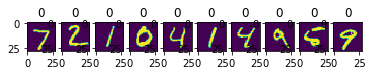

In [7]:
show((x_test,y_test), 0, 10)

In [8]:
plot_model(model, to_file='model.png', show_shapes=True)

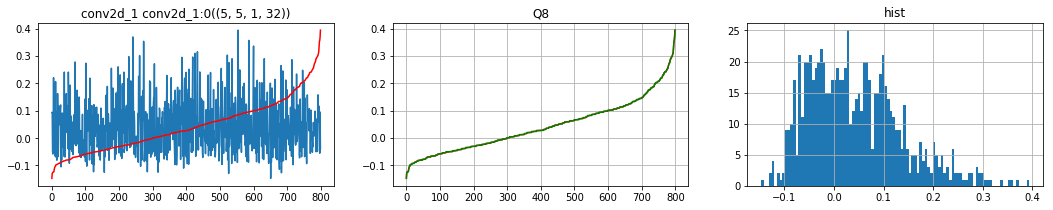

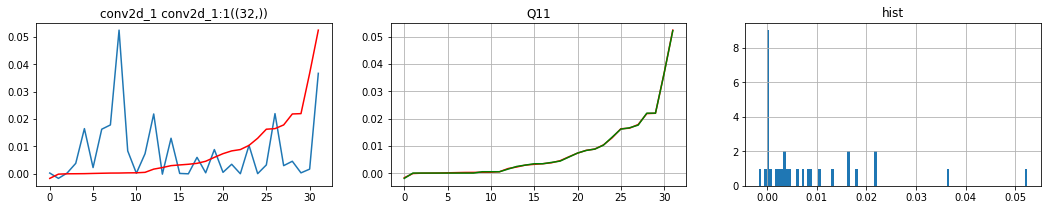

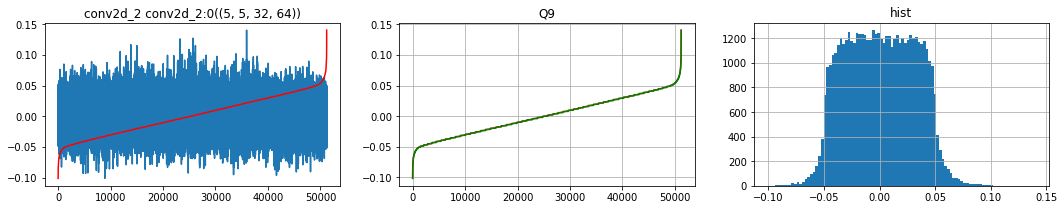

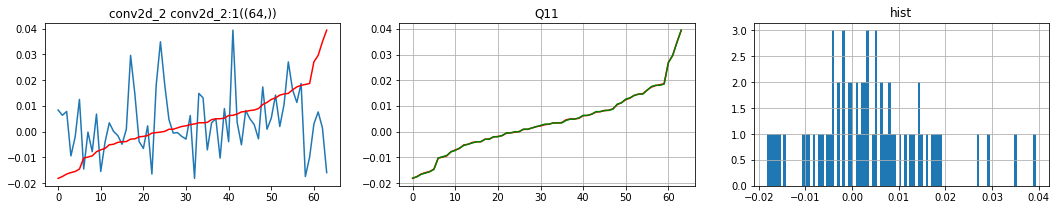

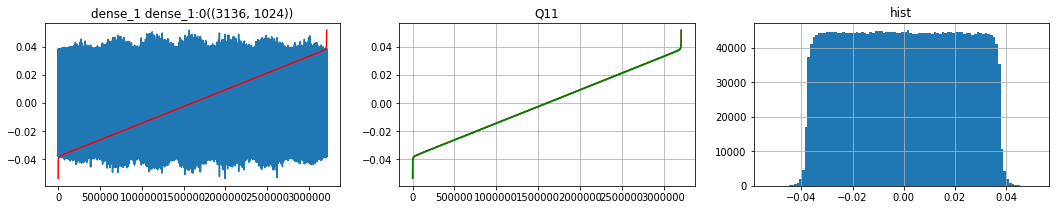

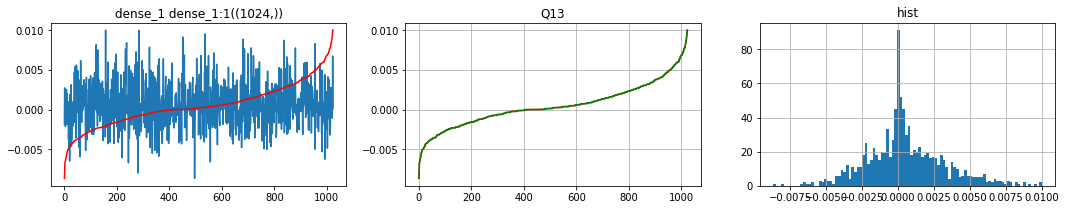

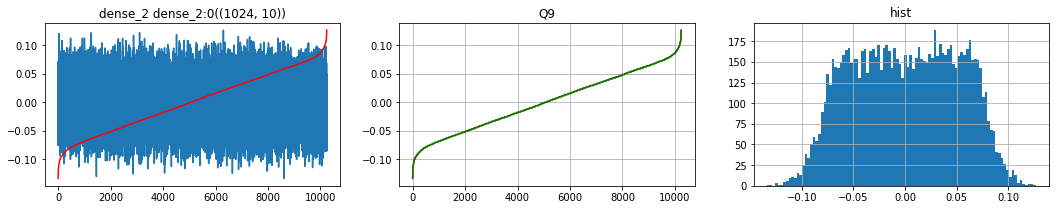

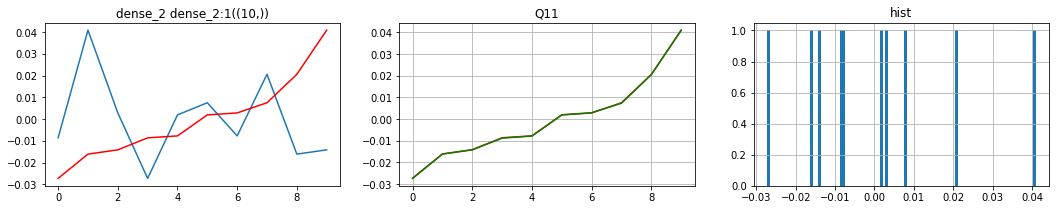

In [9]:
RunSysCmd('rm -fr tmp && mkdir tmp')
lmp = {'conv2d_1':'Conv2D1', 're_lu_1':'ReLU1', 'max_pooling2d_1':'Maxpool1',
         'conv2d_2':'Conv2D2', 're_lu_2':'ReLU2', 'max_pooling2d_2':'Maxpool2',
         'dense_1':'Dense1', 're_lu_3':'ReLU3', 'dense_2':'Dense2', 
         'softmax_1':'Softmax1'}
shift_list = eval(open('.shift_list').read())
X = x_test[5]
f2q(X,shift_list['input_1']).astype(np.int8).tofile('tmp/input.raw')

for layer in model.layers[1:]:
    for i, wt in enumerate(layer.get_weights()):
        name = '%s:%s'%(layer.name,i)
        show_weights(wt, '%s %s(%s)'%(layer.name, name, wt.shape))

In [10]:
RunSysCmd('scons')
RunSysCmd('./mnist')

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
CC mcu/main_cnn.c
LINK mnist
scons: done building targets.

loading input&weights...

INFO: Start compile...
Layer        Activation    output shape      ops          memory            mem life-time
----------------------------------------------------------------------------------------------
 Input      -          - (  28,  28,   1)        0   (  784,  784,    0)    1 - - -  - - - - 
 Conv2D     -          - (  28,  28,  32)   627200   (  784,25088, 3200)    1 1 - -  - - - - 
 ReLU       -          - (  28,  28,  32)        0   (25088,25088,    0)    - - 1 -  - - - - 
 Maxpool    -          - (  14,  14,  32)        0   (25088, 6272,    0)    1 - 1 -  - - - - 
 Conv2D     -          - (  14,  14,  64)  10035200   ( 6272,12544, 6400)    1 1 - -  - - - - 
 ReLU       -          - (  14,  14,  64)        0   (12544,12544,    0)    - - 1 -  - - - - 
 Maxpool    -          - (   7,   7,  6

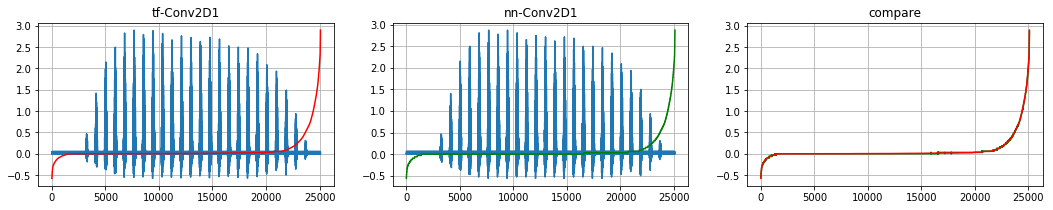

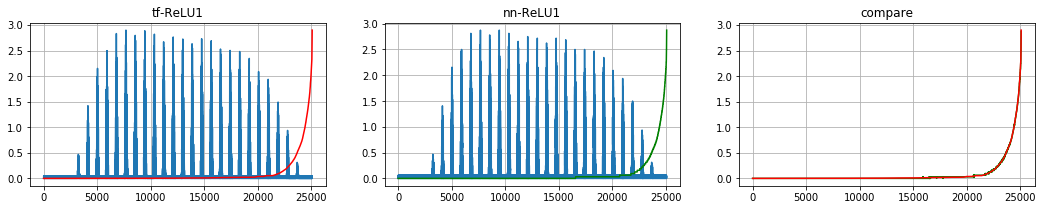

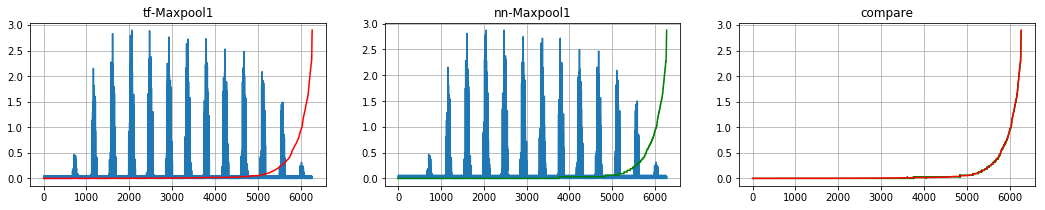

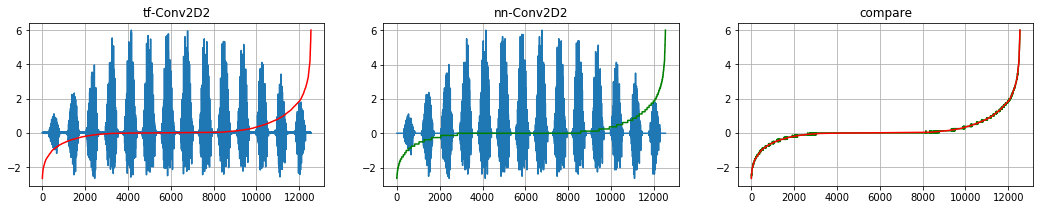

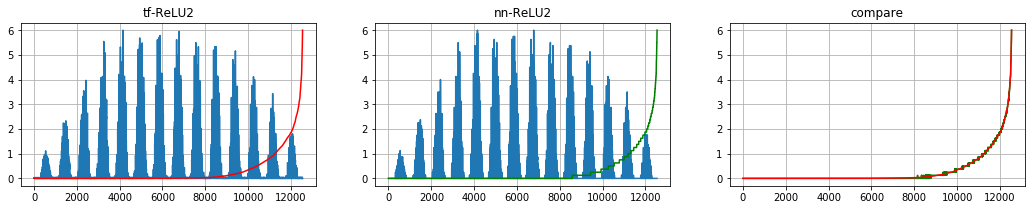

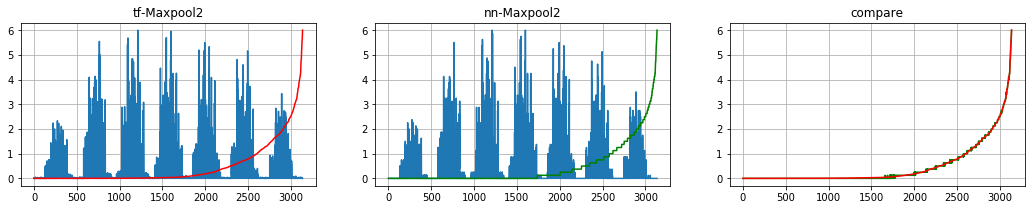

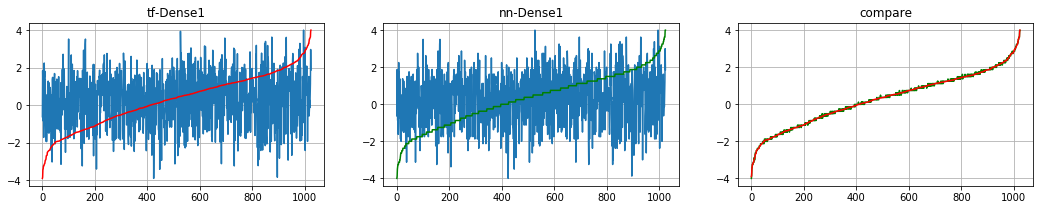

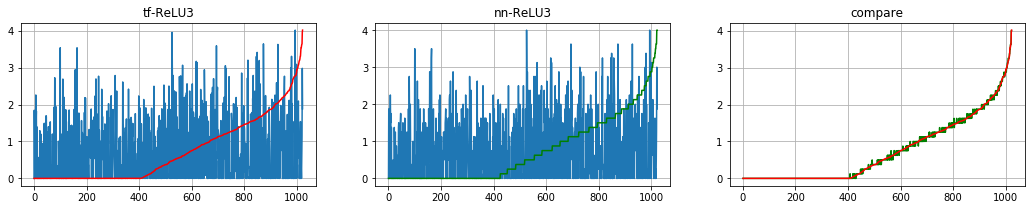

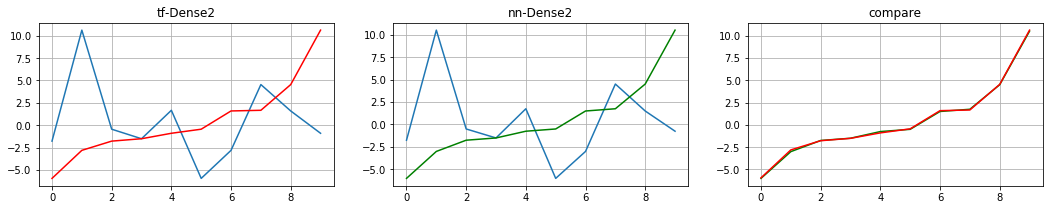

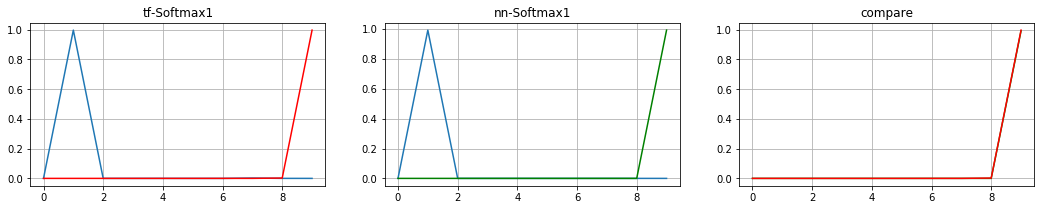

In [11]:
X = X.reshape(1,28,28,1)
for layer in model.layers[1:]:
    if(layer.name in ['flatten_1']):continue
    layer_model = Model(inputs=model.input, outputs=layer.output)
    outR = layer_model.predict(X)
    name= lmp[layer.name]
    Q = shift_list[layer.name]
    out = q2f(np.fromfile('tmp/%s.raw'%(name),dtype=np.int8),Q)
    compare(outR,out, name)

In [14]:
rP = 0
for i,im in enumerate(x_test):
    X = im
    f2q(X,shift_list['input_1']).astype(np.int8).tofile('tmp/input.raw')
    if(0 == os.system('./mnist > /dev/null')):
        out = q2f(np.fromfile('tmp/Softmax1.raw',dtype=np.int8),7)
        out = np.asarray(out)
        num, prop = out.argmax(), out[out.argmax()]
        rnum = y_test[i]
        if((rnum == num) and (prop > 0.8)):
            #print('test image %d is %d, predict correctly with prop %s'%(i, rnum, prop))
            rP += 1
        if((i>0) and ((i%1000)==0)):
            print('%.1f%%(%s) out of %s is correct predicted'%(rP*100.0/i, rP, i))
            break

print('%.1f%%(%s) out of %s is correct predicted'%(rP*100.0/i, rP, i))

91.3%(913) out of 1000 is correct predicted
91.3%(913) out of 1000 is correct predicted
